In [10]:
# 1. Imports and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

from torch_geometric.data import DataLoader
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Fixed subnode geometry for 11 node groups
x_subnodes = [
    [1.0],
    [1.0, 1.0, 0.5],
    [1.0, 1.0, 0.0],
    [0.5, 0.5, 1.0],
    [0.5],
    [0.5, 0.5, 0.0],
    [1.0, 0.0, 0.0],
    [0.5, 0.0, 0.0],
    [0.0],
    [1.0, 0.5, 0.0],
    [1.0, 0.5, 0.0],
]

y_subnodes = [
    [1.0],
    [1.0, 0.5, 1.0],
    [1.0, 0.0, 1.0],
    [0.5, 1.0, 0.5],
    [0.5],
    [0.5, 0.0, 0.5],
    [0.0, 1.0, 0.0],
    [0.0, 0.5, 0.0],
    [0.0],
    [0.5, 0.0, 1.0],
    [0.0, 1.0, 0.5],
]

z_subnodes = [
    [1.0],
    [0.5, 1.0, 1.0],
    [0.0, 1.0, 1.0],
    [1.0, 0.5, 0.5],
    [0.5],
    [0.0, 0.5, 0.5],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 0.5],
    [0.0],
    [0.0, 1.0, 0.5],
    [0.5, 0.0, 1.0],
]

# Precompute subnode coordinate arrays and normalized versions
num_node_groups = len(x_subnodes)
subnode_coords = []
subnode_coords_norm = []

for i in range(num_node_groups):
    xs = np.array(x_subnodes[i], dtype=float)
    ys = np.array(y_subnodes[i], dtype=float)
    zs = np.array(z_subnodes[i], dtype=float)
    coords = np.stack([xs, ys, zs], axis=1)  # [k_i, 3]
    subnode_coords.append(coords)
    # normalize from [0,1] to [-1,1]
    coords_norm = 2.0 * (coords - 0.5)
    subnode_coords_norm.append(coords_norm)

SQRT3 = np.sqrt(3.0)

# Import data
data = pd.read_pickle('../data/connectivity_compliance_matrices.pkl')
data.rename(columns={'ρ': 'rho'}, inplace=True)

# Calculate mean of E1, E2, E3 (kept for compatibility; not used as input)
data['mean_E'] = data[['E1', 'E2', 'E3']].mean(axis=1)

# Extract relevant columns
X = data[['connectivity_matrix', 'compliance_matrix', 'rho', 'mean_E']]
display(X.head())


,connectivity_matrix,compliance_matrix,rho,mean_E
0,"[[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[[16.24421666, -4.390589664, -4.392122358, 0.0...",0.3,0.061528
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[22.19444352, -7.184492662, -7.167363015, 0.0...",0.3,0.045108
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[21.44865816, -6.46782716, -6.446425604, 0.0,...",0.3,0.046636
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[15.24763491, -3.931170891, -3.930385075, 0.0...",0.3,0.065567
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[23.16273271, -5.511611079, -5.663410447, 0.0...",0.3,0.043226


In [11]:
# 2. Graph Construction Utilities

def build_node_features(conn_mat, rho):
    """
    Build node feature matrix for a single graph.
    Features per node i:
      [subnode_count, degree, 3*(x,y,z) of up to 3 subnodes (normalized and padded)]
    """
    num_nodes = conn_mat.shape[0]
    degrees = conn_mat.sum(axis=1)  # degree of connectivity

    node_feats = []
    for i in range(num_nodes):
        coords_norm = subnode_coords_norm[i]  # [k_i, 3], fixed across samples
        k_i = coords_norm.shape[0]
        # pad / truncate to exactly 3 subnodes per group
        if k_i >= 3:
            coords3 = coords_norm[:3]
        else:
            # repeat first subnode to fill remaining slots
            reps = 3 - k_i
            pad = np.repeat(coords_norm[0:1, :], reps, axis=0)
            coords3 = np.vstack([coords_norm, pad])
        coords_flat = coords3.reshape(-1)  # 9-D
        feat = [float(k_i), float(degrees[i])] + coords_flat.tolist()
        node_feats.append(feat)

    x = torch.tensor(node_feats, dtype=torch.float32)
    return x  # [num_nodes, 11]


def compute_edge_index_and_attr(conn_mat):
    """
    From symmetric connectivity matrix, build edge_index and edge_attr.
    edge_attr is normalized minimum subnode-subnode distance per edge.
    """
    # edge_index as all nonzero entries (directed edges)
    edges = np.array(np.nonzero(conn_mat)).T  # shape [E, 2]
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    # compute min distance per (i,j) using original (unnormalized) coordinates
    dists = []
    for (i, j) in edges:
        coords_i = subnode_coords[i]  # [k_i, 3]
        coords_j = subnode_coords[j]  # [k_j, 3]
        # pairwise distances
        diff = coords_i[:, None, :] - coords_j[None, :, :]
        dist_matrix = np.linalg.norm(diff, axis=2)
        d_ij = float(dist_matrix.min())
        # normalize to [0,1] by sqrt(3)
        d_norm = d_ij / SQRT3
        dists.append([d_norm])

    edge_attr = torch.tensor(dists, dtype=torch.float32)  # [E, 1]
    return edge_index, edge_attr


def construct_graph_data(row):
    conn_mat = row['connectivity_matrix']
    C_mat = row['compliance_matrix']
    rho = float(row['rho'])

    # normalize compliance matrix per-sample
    min_val = np.min(C_mat)
    max_val = np.max(C_mat)
    denom = max_val - min_val
    if denom == 0.0:
        C_norm = np.zeros_like(C_mat, dtype=float)
    else:
        C_norm = (C_mat - min_val) / denom

    # node features
    x = build_node_features(conn_mat, rho)  # [num_nodes, 11]

    # edges and edge attributes (distances)
    edge_index, edge_attr = compute_edge_index_and_attr(conn_mat)

    graph_data = Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,  # normalized distances
        y=torch.tensor(C_norm.flatten(), dtype=torch.float32),
        rho=torch.tensor([rho], dtype=torch.float32),
    )
    return graph_data


# Preview individual sample / edge matrix
sample = X.iloc[0]
conn_mat = sample['connectivity_matrix']
C_mat = sample['compliance_matrix']
edge_index_preview, edge_attr_preview = compute_edge_index_and_attr(conn_mat)
display(conn_mat)
sample_data = Data(
    edge_index=edge_index_preview,
    edge_attr=edge_attr_preview,
    y=torch.tensor(C_mat, dtype=torch.float32)
)
print(f"Edge index:\n{sample_data.edge_index}")
print(f"Edge attr (normalized distances):\n{sample_data.edge_attr}")
print(f"Compliance matrix:\n{sample_data.y}")


array([[0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.]])

Edge index:
tensor([[ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  4,  4,  6,  6,  7,  7, 10, 10],
        [ 1,  4,  0,  7,  3, 10,  2,  4,  0,  3,  6, 10,  4,  6,  1,  7,  2,  4]])
Edge attr (normalized distances):
tensor([[0.2887],
        [0.5000],
        [0.2887],
        [0.7071],
        [0.4082],
        [0.2887],
        [0.4082],
        [0.2887],
        [0.5000],
        [0.2887],
        [0.5000],
        [0.4082],
        [0.5000],
        [0.0000],
        [0.7071],
        [0.0000],
        [0.2887],
        [0.4082]])
Compliance matrix:
tensor([[16.2442, -4.3906, -4.3921,  0.0000,  0.0000,  0.0000],
        [-4.3906, 16.2539, -4.3922,  0.0000,  0.0000,  0.0000],
        [-4.3921, -4.3922, 16.2602,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, 38.9590,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000, 39.0762,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 39.0137]])


In [12]:
# 3. Build Graph Dataset & Print Stats

graph_data_list = X.apply(construct_graph_data, axis=1).tolist()
print(f"Constructed {len(graph_data_list)} graph data objects.")

train_data, test_data = train_test_split(
    graph_data_list, test_size=0.2, random_state=42
)
print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")
print('len(y) per graph =', len(train_data[0].y))
print(train_data[0])

num_node_features = int(train_data[0].x.shape[1])  # features per node
output_dim = int(train_data[0].y.shape[0])        # flattened compliance matrix length
num_nodes = int(np.sqrt(output_dim))
print(f"Node features per node: {num_node_features}")
print(f"Number of nodes per graph (sqrt of output dim): {num_nodes}")
print(f"Output dim (flattened compliance matrix): {output_dim}")

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=32, shuffle=False)


Constructed 2624 graph data objects.
Training set size: 2099
Testing set size: 525
len(y) per graph = 36
Data(x=[11, 11], edge_index=[2, 21], edge_attr=[21, 1], y=[36], rho=[1])
Node features per node: 11
Number of nodes per graph (sqrt of output dim): 6
Output dim (flattened compliance matrix): 36


In [13]:
# 4. GNN Model Definitions

import torch
from torch.nn import Linear, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import math
from torch import nn

embedding_size = 64  # not strictly used


class GNN_v1(torch.nn.Module):
    """Graph-level regressor: GCNConv + pooling + MLP, uses edge weights and rho."""
    def __init__(
        self,
        in_channels,
        embedding_size=128,
        out_dim=36,
        dropout=0.0,
        mlp_layers=1,
        hidden_neurons=64,
        num_convs=1,
        conv_channels=None
    ):
        super(GNN_v1, self).__init__()
        torch.manual_seed(42)
        if conv_channels is not None:
            widths = list(map(int, conv_channels))
            assert len(widths) >= 1, "conv_channels must have at least one width"
        else:
            widths = [int(embedding_size)] * max(int(num_convs), 1)

        convs = []
        in_c = in_channels
        for w in widths:
            convs.append(GCNConv(in_c, w))
            in_c = w
        self.convs = torch.nn.ModuleList(convs)
        self.dropout = Dropout(dropout)
        last_embed = widths[-1]

        # +1 for rho concatenated to pooled embedding
        d_in = last_embed * 2 + 1  # concat of [gmp, gap] and rho
        hdim = last_embed if hidden_neurons is None else int(hidden_neurons)

        layers = []
        if mlp_layers <= 0:
            layers.append(Linear(d_in, out_dim))
        else:
            layers += [Linear(d_in, hdim), torch.nn.ReLU(), Dropout(dropout)]
            for _ in range(mlp_layers - 1):
                layers += [Linear(hdim, hdim), torch.nn.ReLU(), Dropout(dropout)]
            layers.append(Linear(hdim, out_dim))
        self.mlp = torch.nn.Sequential(*layers)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_weight = data.edge_attr.view(-1) if hasattr(data, 'edge_attr') else None
        rho = data.rho.to(x.device)  # [B,1] after batching

        h = x
        for conv in self.convs:
            h = conv(h, edge_index, edge_weight=edge_weight)
            h = F.relu(h)

        hg = torch.cat([gmp(h, batch), gap(h, batch)], dim=1)  # [B, 2*last_embed]

        # ensure rho has shape [B,1]
        if rho.dim() == 1:
            rho = rho.unsqueeze(1)
        hg = torch.cat([hg, rho], dim=1)

        hg = self.dropout(hg)
        out = self.mlp(hg)  # [batch_size, out_dim]
        return out


class MultiHeadGraphAttention(nn.Module):
    """
    Multi-head self-attention over nodes, with adjacency mask and optional distance penalty.

    X: [B, N, F_in]
    A: [B, N, N]  (0/1; 1 means "can attend")
    D: [B, N, N]  (normalized distances; 0 for non-edges)
    returns: [B, N, F_out]
    """
    def __init__(self, in_dim, out_dim, num_heads=4, dropout=0.1):
        super().__init__()
        assert out_dim % num_heads == 0, "out_dim must be divisible by num_heads"

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_heads = num_heads
        self.d_k = out_dim // num_heads

        self.W_q = nn.Linear(in_dim, out_dim)
        self.W_k = nn.Linear(in_dim, out_dim)
        self.W_v = nn.Linear(in_dim, out_dim)

        self.out_proj = nn.Linear(out_dim, out_dim)
        self.dropout = nn.Dropout(dropout)

        # learnable scale for distance penalty
        self.dist_scale = nn.Parameter(torch.tensor(1.0))

    def forward(self, X, A, D=None):
        # X: [B, N, F_in], A: [B, N, N], D: [B, N, N] or None
        B, N, _ = X.shape

        Q = self.W_q(X)  # [B, N, out_dim]
        K = self.W_k(X)
        V = self.W_v(X)

        h = self.num_heads
        d_k = self.d_k

        # [B, N, out_dim] -> [B, h, N, d_k]
        Q = Q.view(B, N, h, d_k).transpose(1, 2)
        K = K.view(B, N, h, d_k).transpose(1, 2)
        V = V.view(B, N, h, d_k).transpose(1, 2)

        # attention scores: [B, h, N, N]
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)

        if D is not None:
            # D: [B, N, N] -> [B, 1, N, N], broadcast over heads
            scores = scores - self.dist_scale * D.unsqueeze(1)

        # adjacency mask: where A == 0, set score to -inf
        A_expanded = A.unsqueeze(1)  # [B, 1, N, N]
        mask = (A_expanded <= 0)
        scores = scores.masked_fill(mask, -1e9)

        attn = torch.softmax(scores, dim=-1)  # [B, h, N, N]
        attn = self.dropout(attn)

        # weighted sum of V: [B, h, N, d_k]
        out = torch.matmul(attn, V)

        # merge heads: [B, N, h * d_k]
        out = out.transpose(1, 2).contiguous().view(B, N, h * d_k)

        # final linear
        out = self.out_proj(out)  # [B, N, out_dim]
        return out


class GNN_v2_Attention(nn.Module):
    """
    Attention-enabled graph regressor using MultiHeadGraphAttention and rho.
    """
    def __init__(
        self,
        in_channels,
        hidden_dim=64,
        out_dim=36,
        num_heads=4,
        num_layers=3,
        mlp_layers=1,
        hidden_neurons=64,
        dropout=0.0,
    ):
        super().__init__()
        torch.manual_seed(42)

        layers = []
        dim = in_channels
        for _ in range(num_layers):
            layers.append(
                MultiHeadGraphAttention(
                    in_dim=dim,
                    out_dim=hidden_dim,
                    num_heads=num_heads,
                    dropout=dropout,
                )
            )
            dim = hidden_dim
        self.att_layers = nn.ModuleList(layers)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        # graph-level MLP head; +1 for rho
        d_in = hidden_dim + 1
        hdim = hidden_dim if hidden_neurons is None else int(hidden_neurons)
        layers = []
        if mlp_layers <= 0:
            layers.append(nn.Linear(d_in, out_dim))
        else:
            layers += [nn.Linear(d_in, hdim), nn.ReLU(), nn.Dropout(dropout)]
            for _ in range(mlp_layers - 1):
                layers += [nn.Linear(hdim, hdim), nn.ReLU(), nn.Dropout(dropout)]
            layers.append(nn.Linear(hdim, out_dim))
        self.mlp = nn.Sequential(*layers)

    def _build_adj_and_dist_per_graph(self, x, edge_index, batch, edge_attr):
        """
        Build dense adjacency matrices A_b and distance matrices D_b for each graph b in the batch.
        Returns:
            A_list: list of [N_b, N_b] tensors (0/1 adjacency)
            D_list: list of [N_b, N_b] tensors (normalized distances, 0 for non-edges)
            X_list: list of [N_b, F] node-feature tensors per graph
        """
        device = x.device
        num_graphs = int(batch.max().item()) + 1
        src, dst = edge_index
        edge_attr_flat = edge_attr.view(-1).to(device)  # [E]

        A_list, D_list, X_list = [], [], []

        for g in range(num_graphs):
            node_mask = (batch == g)
            idx = node_mask.nonzero(as_tuple=False).view(-1)  # global indices of nodes
            X_g = x[idx]  # [N_g, F]
            N_g = X_g.size(0)

            mapping = -torch.ones(x.size(0), dtype=torch.long, device=device)
            mapping[idx] = torch.arange(N_g, device=device)

            # edges within this graph
            edges_mask = node_mask[src] & node_mask[dst]
            src_local = mapping[src[edges_mask]]
            dst_local = mapping[dst[edges_mask]]
            edge_attr_g = edge_attr_flat[edges_mask]

            A_g = torch.zeros(N_g, N_g, device=device)
            D_g = torch.zeros(N_g, N_g, device=device)

            A_g[src_local, dst_local] = 1.0
            D_g[src_local, dst_local] = edge_attr_g

            # make symmetric (assuming undirected)
            A_g[dst_local, src_local] = 1.0
            D_g[dst_local, src_local] = edge_attr_g

            # self-loops in adjacency; distances on diagonal remain 0
            A_g.fill_diagonal_(1.0)

            A_list.append(A_g)
            D_list.append(D_g)
            X_list.append(X_g)

        return A_list, D_list, X_list

    def forward(self, data):
        """
        data: batched PyG Data object with attributes:
            x: [N_total, F]
            edge_index: [2, E_total]
            edge_attr: [E_total, 1]
            batch: [N_total]
            rho: [B, 1]
        """
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_attr = data.edge_attr
        rho = data.rho.to(x.device)  # [B,1]

        A_list, D_list, X_list = self._build_adj_and_dist_per_graph(
            x, edge_index, batch, edge_attr
        )

        graph_embs = []
        for A_g, D_g, X_g in zip(A_list, D_list, X_list):
            # single-graph batch dimension
            h = X_g.unsqueeze(0)  # [1, N_g, F]
            A = A_g.unsqueeze(0)  # [1, N_g, N_g]
            D = D_g.unsqueeze(0)  # [1, N_g, N_g]

            for att in self.att_layers:
                h = att(h, A, D)          # [1, N_g, hidden_dim]
                h = self.activation(h)
                h = self.dropout(h)

            # graph-level embedding mean over nodes
            g_emb = h.mean(dim=1)  # [1, hidden_dim]
            graph_embs.append(g_emb)

        # stack all graph embeddings in the batch: [B, hidden_dim]
        graph_emb = torch.cat(graph_embs, dim=0)

        # concatenate rho: ensure shape [B,1]
        if rho.dim() == 1:
            rho = rho.unsqueeze(1)
        graph_emb = torch.cat([graph_emb, rho], dim=1)

        out = self.mlp(graph_emb)  # [batch_size, out_dim]
        return out


Starting training (Attention)...
[ATTN] Epoch 0 | Train MSE 0.039001
[ATTN] Epoch 5 | Train MSE 0.009494
[ATTN] Epoch 10 | Train MSE 0.006856
[ATTN] Epoch 15 | Train MSE 0.005489
[ATTN] Epoch 20 | Train MSE 0.004895
[ATTN] Epoch 25 | Train MSE 0.004392
[ATTN] Epoch 30 | Train MSE 0.004173
[ATTN] Epoch 35 | Train MSE 0.003856
[ATTN] Epoch 40 | Train MSE 0.003694
[ATTN] Epoch 45 | Train MSE 0.003387
[ATTN] Epoch 50 | Train MSE 0.003390
[ATTN] Epoch 55 | Train MSE 0.003114
[ATTN] Epoch 60 | Train MSE 0.003044
[ATTN] Epoch 65 | Train MSE 0.003022
[ATTN] Epoch 70 | Train MSE 0.002829
[ATTN] Epoch 75 | Train MSE 0.002721
[ATTN] Epoch 80 | Train MSE 0.002591
[ATTN] Epoch 85 | Train MSE 0.002560
[ATTN] Epoch 90 | Train MSE 0.002542
[ATTN] Epoch 95 | Train MSE 0.002549
[ATTN] Epoch 100 | Train MSE 0.002495
[ATTN] Epoch 105 | Train MSE 0.002350
[ATTN] Epoch 110 | Train MSE 0.002277
[ATTN] Epoch 115 | Train MSE 0.002148
[ATTN] Epoch 120 | Train MSE 0.002176
[ATTN] Epoch 125 | Train MSE 0.002164
[

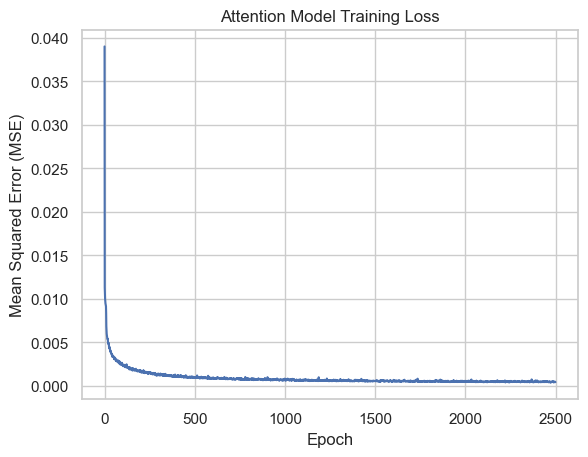

Starting training (GCN)...
[GCN] Epoch 0 | Train MSE 0.025363
[GCN] Epoch 5 | Train MSE 0.006534
[GCN] Epoch 10 | Train MSE 0.005683
[GCN] Epoch 15 | Train MSE 0.005176
[GCN] Epoch 20 | Train MSE 0.004864
[GCN] Epoch 25 | Train MSE 0.004482
[GCN] Epoch 30 | Train MSE 0.004745
[GCN] Epoch 35 | Train MSE 0.004196
[GCN] Epoch 40 | Train MSE 0.003856
[GCN] Epoch 45 | Train MSE 0.003804
[GCN] Epoch 50 | Train MSE 0.003684
[GCN] Epoch 55 | Train MSE 0.003514
[GCN] Epoch 60 | Train MSE 0.003409
[GCN] Epoch 65 | Train MSE 0.003533
[GCN] Epoch 70 | Train MSE 0.003046
[GCN] Epoch 75 | Train MSE 0.003053
[GCN] Epoch 80 | Train MSE 0.003080
[GCN] Epoch 85 | Train MSE 0.002830
[GCN] Epoch 90 | Train MSE 0.002757
[GCN] Epoch 95 | Train MSE 0.002573
[GCN] Epoch 100 | Train MSE 0.002833
[GCN] Epoch 105 | Train MSE 0.002312
[GCN] Epoch 110 | Train MSE 0.002419
[GCN] Epoch 115 | Train MSE 0.002306
[GCN] Epoch 120 | Train MSE 0.002259
[GCN] Epoch 125 | Train MSE 0.002395
[GCN] Epoch 130 | Train MSE 0.002

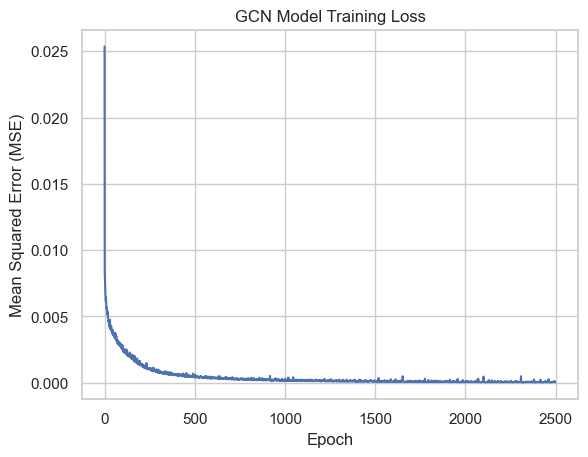

In [15]:
# 5. Training Setup and Loops

def train_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_squared_error = 0.0
    total_elements = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = model(batch)
        target = batch.y.view_as(pred).to(device)
        loss = loss_fn(pred, target)
        loss.backward()
        optimizer.step()

        batch_se = F.mse_loss(pred, target, reduction='sum').item()
        total_squared_error += batch_se
        total_elements += pred.numel()
    return total_squared_error / total_elements if total_elements > 0 else float('nan')


# ---- Train Attention Model ----
model_attn = GNN_v2_Attention(
    in_channels=num_node_features,
    hidden_dim=64,
    out_dim=output_dim,
    num_heads=4,
    num_layers=3,
    mlp_layers=2,
    hidden_neurons=128,
    dropout=0.1,
).to(device)

loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer_attn = torch.optim.Adam(model_attn.parameters(), lr=0.0005)

print("Starting training (Attention)...")
attn_losses = []
EPOCHS = 2500
for epoch in range(EPOCHS):
    train_loss = train_epoch(model_attn, train_loader, optimizer_attn, loss_fn, device)
    attn_losses.append(train_loss)
    if epoch % 5 == 0:
        print(f"[ATTN] Epoch {epoch} | Train MSE {train_loss:.6f}")

sns.set(style="whitegrid")
ax = sns.lineplot(x=list(range(len(attn_losses))), y=attn_losses)
ax.set(xlabel="Epoch", ylabel="Mean Squared Error (MSE)")
plt.title("Attention Model Training Loss")
plt.show()

# ---- Train GCN Model ----
model_gcn = GNN_v1(
    in_channels=num_node_features,
    embedding_size=128,
    out_dim=output_dim,
    dropout=0.0,
    mlp_layers=2,
    hidden_neurons=128,
    num_convs=1
).to(device)

optimizer_gcn = torch.optim.Adam(model_gcn.parameters(), lr=0.0005)

print("Starting training (GCN)...")
gcn_losses = []
EPOCHS = 2500
for epoch in range(EPOCHS):
    train_loss = train_epoch(model_gcn, train_loader, optimizer_gcn, loss_fn, device)
    gcn_losses.append(train_loss)
    if epoch % 5 == 0:
        print(f"[GCN] Epoch {epoch} | Train MSE {train_loss:.6f}")

sns.set(style="whitegrid")
ax = sns.lineplot(x=list(range(len(gcn_losses))), y=gcn_losses)
ax.set(xlabel="Epoch", ylabel="Mean Squared Error (MSE)")
plt.title("GCN Model Training Loss")
plt.show()


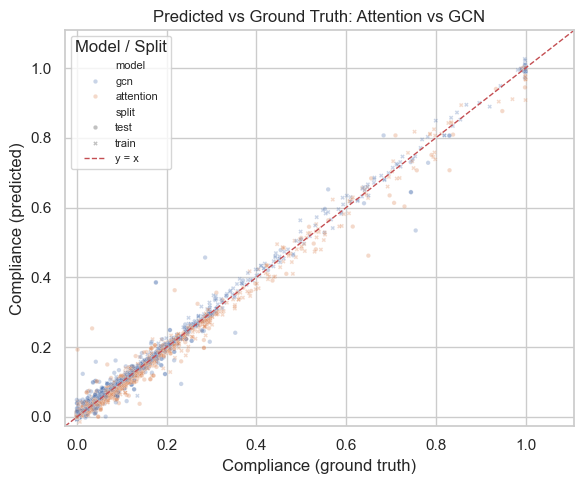

In [16]:
# 6. Evaluation and Prediction Plotting (both models, faster)

def evaluate_model(loader_dict, model, device, model_name):
    model.eval()
    ys, preds, splits = [], [], []
    with torch.no_grad():
        for split_name, split_loader in loader_dict.items():
            for batch in split_loader:
                batch = batch.to(device)
                pred = model(batch)                     # [B, out_dim]
                target = batch.y.view_as(pred)          # [B, out_dim]
                p = pred.detach().cpu().numpy().ravel()
                t = target.detach().cpu().numpy().ravel()
                ys.append(t)
                preds.append(p)
                splits.append(np.full_like(t, fill_value=split_name, dtype=object))

    y_true = np.concatenate(ys, axis=0)
    y_pred = np.concatenate(preds, axis=0)
    split_arr = np.concatenate(splits, axis=0)

    return pd.DataFrame({
        "y_true": y_true,
        "y_pred": y_pred,
        "split": split_arr,
        "model": model_name
    })


loader_dict = {"train": train_loader, "test": test_loader}

attn_df = evaluate_model(loader_dict, model_attn, device, "attention")
gcn_df  = evaluate_model(loader_dict, model_gcn,  device, "gcn")

all_df = pd.concat([attn_df, gcn_df], ignore_index=True)

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(6, 5))
sns.scatterplot(
    data=all_df.sample(min(len(all_df), 5000), random_state=0),
    x="y_true",
    y="y_pred",
    hue="model",
    style="split",
    alpha=0.3,
    s=10,
    ax=ax
)
xy_min = float(min(all_df["y_true"].min(), all_df["y_pred"].min()))
xy_max = float(max(all_df["y_true"].max(), all_df["y_pred"].max()))
ax.axline((0, 0), slope=1.0, color="r", linestyle="--", linewidth=1.0, label="y = x")
ax.set_xlim(xy_min, xy_max)
ax.set_ylim(xy_min, xy_max)
ax.set_xlabel("Compliance (ground truth)")
ax.set_ylabel("Compliance (predicted)")
ax.legend(title="Model / Split", fontsize=8)
ax.set_title("Predicted vs Ground Truth: Attention vs GCN")
plt.tight_layout()
plt.show()


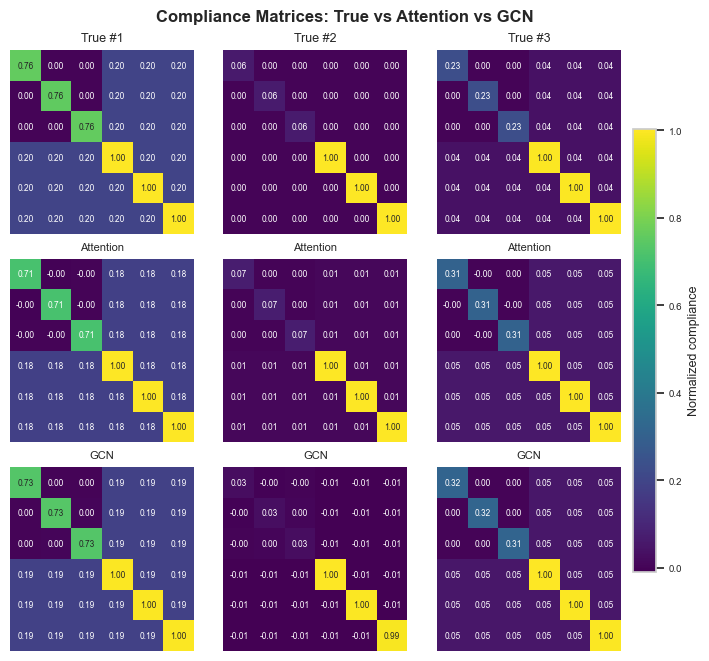

In [17]:
from torch_geometric.data import Batch

def visualize_compliance_matrices_dual(
    model_attn,
    model_gcn,
    dataset,
    device,
    num_examples=3,
    fmt=".2f"
):
    model_attn.eval()
    model_gcn.eval()

    if len(dataset) == 0:
        print("Dataset is empty; nothing to visualize.")
        return

    num_examples = min(num_examples, len(dataset))
    indices = np.random.choice(len(dataset), size=num_examples, replace=False)
    samples = [dataset[i] for i in indices]

    batch = Batch.from_data_list(samples).to(device)

    with torch.no_grad():
        pred_attn_all = model_attn(batch).cpu().numpy()
        pred_gcn_all  = model_gcn(batch).cpu().numpy()

    true_mats, attn_mats, gcn_mats = [], [], []
    for i, data_item in enumerate(samples):
        true_mat = data_item.y.view(num_nodes, num_nodes).cpu().numpy()
        attn_mat = pred_attn_all[i].reshape(num_nodes, num_nodes)
        gcn_mat  = pred_gcn_all[i].reshape(num_nodes, num_nodes)
        true_mats.append(true_mat)
        attn_mats.append(attn_mat)
        gcn_mats.append(gcn_mat)

    all_vals = np.concatenate(
        [m.ravel() for m in (true_mats + attn_mats + gcn_mats)]
    )
    vmin = all_vals.min()
    vmax = all_vals.max()

    fig, axes = plt.subplots(
        3,
        num_examples,
        figsize=(2.4 * num_examples, 6.5),
        constrained_layout=True
    )
    if num_examples == 1:
        axes = np.array(axes).reshape(3, 1)

    im_for_cbar = None
    annot_kws = {"fontsize": 6}

    for i, (true_mat, attn_mat, gcn_mat) in enumerate(
        zip(true_mats, attn_mats, gcn_mats)
    ):
        ax_true = axes[0, i]
        ax_attn = axes[1, i]
        ax_gcn  = axes[2, i]

        im_true = sns.heatmap(
            true_mat,
            ax=ax_true,
            cmap="viridis",
            vmin=vmin,
            vmax=vmax,
            annot=True,
            fmt=fmt,
            annot_kws=annot_kws,
            square=True,
            cbar=False
        )
        ax_true.set_title(f"True #{i+1}", fontsize=9)
        ax_true.set_xticks([])
        ax_true.set_yticks([])

        im_attn = sns.heatmap(
            attn_mat,
            ax=ax_attn,
            cmap="viridis",
            vmin=vmin,
            vmax=vmax,
            annot=True,
            fmt=fmt,
            annot_kws=annot_kws,
            square=True,
            cbar=False
        )
        ax_attn.set_title("Attention", fontsize=8)
        ax_attn.set_xticks([])
        ax_attn.set_yticks([])

        im_gcn = sns.heatmap(
            gcn_mat,
            ax=ax_gcn,
            cmap="viridis",
            vmin=vmin,
            vmax=vmax,
            annot=True,
            fmt=fmt,
            annot_kws=annot_kws,
            square=True,
            cbar=False
        )
        ax_gcn.set_title("GCN", fontsize=8)
        ax_gcn.set_xticks([])
        ax_gcn.set_yticks([])

        if im_for_cbar is None:
            im_for_cbar = im_true.collections[0]

    cbar = fig.colorbar(
        im_for_cbar,
        ax=axes.ravel().tolist(),
        fraction=0.035,
        pad=0.02
    )
    cbar.set_label("Normalized compliance", fontsize=9)
    cbar.ax.tick_params(labelsize=7)

    fig.suptitle(
        "Compliance Matrices: True vs Attention vs GCN",
        fontsize=12,
        weight="bold"
    )
    plt.show()


# Call after both models are trained
visualize_compliance_matrices_dual(
    model_attn=model_attn,
    model_gcn=model_gcn,
    dataset=test_data,
    device=device,
    num_examples=3,
    fmt=".2f"
)
